In [127]:
import numpy as np
import control
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


# Controller Simulation

Initialization from designed controller

In [128]:
A_d = np.load('data/statespace_models/A_discrete.npy')
B_d = np.load('data/statespace_models/B_discrete.npy')
C_d = np.load('data/statespace_models/C_discrete.npy')
D_d = np.load('data/statespace_models/D_discrete.npy')
dt = float(np.load('data/statespace_models/dt_discrete.npy'))
sys_d = control.ss(A_d, B_d, C_d, D_d, dt)

In [129]:
A_c = np.load('data/statespace_models/A_continuous.npy')
B_c = np.load('data/statespace_models/B_continuous.npy')
C_c = np.load('data/statespace_models/C_continuous.npy')
D_c = np.load('data/statespace_models/D_continuous.npy')
sys_c = control.ss(A_c, B_c, C_c, D_c)

In [130]:
L_c = np.load('data/gain_matrices/L_Continuous.npy')
L_d = np.load('data/gain_matrices/L_Discrete.npy')

# Load controller gains
K_c = np.load('data/gain_matrices/K_Continuous.npy')
K_d = np.load('data/gain_matrices/K_Discrete.npy')

In [131]:
# Initial State
x0 = np.array([0.0, 0.0, 0.1, 0.1])

Controller Log

In [132]:
T_c = np.linspace(0,10, 200)
U_c = np.zeros_like(T_c)    # disturbance
U_c += np.exp(-((T_c - 5.0)/0.3)**2) * 0.5
U_c += np.exp(-((T_c - 8.0)/0.2)**2) * (-0.15)

dt = sys_d.dt
T_d = np.arange(0, 10, dt)
U_d = np.interp(T_d, T_c, U_c)


In [133]:
# No control response for continuous
T_out_noControl_c, x_out_noControl_c  = control.forced_response(sys_c, T_c, U=0*T_c, X0=x0)

# No control response for discrete
T_out_noControl_d, x_out_noControl_d  = control.forced_response(sys_d, T_d, U=0*T_d, X0=x0)

In [134]:
# LQR
A_cl_c = sys_c.A - sys_c.B @ K_c
sys_cl_c = control.ss(A_cl_c, sys_c.B, sys_c.C, sys_c.D)
T_out_lqr_c, x_out_lqr_c  = control.forced_response(sys_cl_c, T_c, U=U_c, X0=x0)
x_out_noisy_lqr_c = x_out_lqr_c + 0.0002 * np.random.randn(*T_out_lqr_c.shape)    #noise
tau_lqr_c = (-K_c @ x_out_noisy_lqr_c).flatten()  # tau

# dLQR
A_cl_d = sys_d.A - sys_d.B @ K_d
sys_cl_d = control.ss(A_cl_d, sys_d.B, sys_d.C, sys_d.D, sys_d.dt)
T_out_lqr_d, x_out_lqr_d = control.forced_response(sys_cl_d, T_d, U=U_d, X0=x0)
x_out_noisy_lqr_d = x_out_lqr_d + 0.0002 * np.random.randn(*T_out_lqr_d.shape)    #noise
tau_lqr_d = (-K_d @ x_out_noisy_lqr_d).flatten() 

In [135]:
from utils import lqg_simulation_linear_continuous
from utils import lqg_simulation_linear_discrete
# Time settings
# For continuous LQG simulation
t_span_c = (T_c[0], T_c[-1])
t_eval_c = T_c

# For discrete LQG simulation
t_eval_d = T_d

def disturbance_function(t):
    return (
        np.exp(-((t - 5.0) / 0.3) ** 2) * 0.5
        + np.exp(-((t - 8.0) / 0.2) ** 2) * (-0.15)
    )

In [ ]:
# Run simulation
T_lqg_c, x_true_lqg_c, x_hat_lqg_c, tau_lqg_c = lqg_simulation_linear_continuous(
    x0, sys_c, K_c, L_c, t_span_c, t_eval_c,
    # measurement_noise_std=0.0002,
    # disturbance_func=disturbance_function,
    # impulse_time=2.0,
    # impulse_magnitude=1.0
)

T_lqg_d, x_true_lqg_d, x_hat_lqg_d, tau_lqg_d = lqg_simulation_linear_discrete(
    x0, sys_d, K_d, L_d, t_eval_d,
    # measurement_noise_std=0.0002,
    # disturbance_func=disturbance_function,
    # impulse_time=2.0,
    # impulse_magnitude=1.0
)

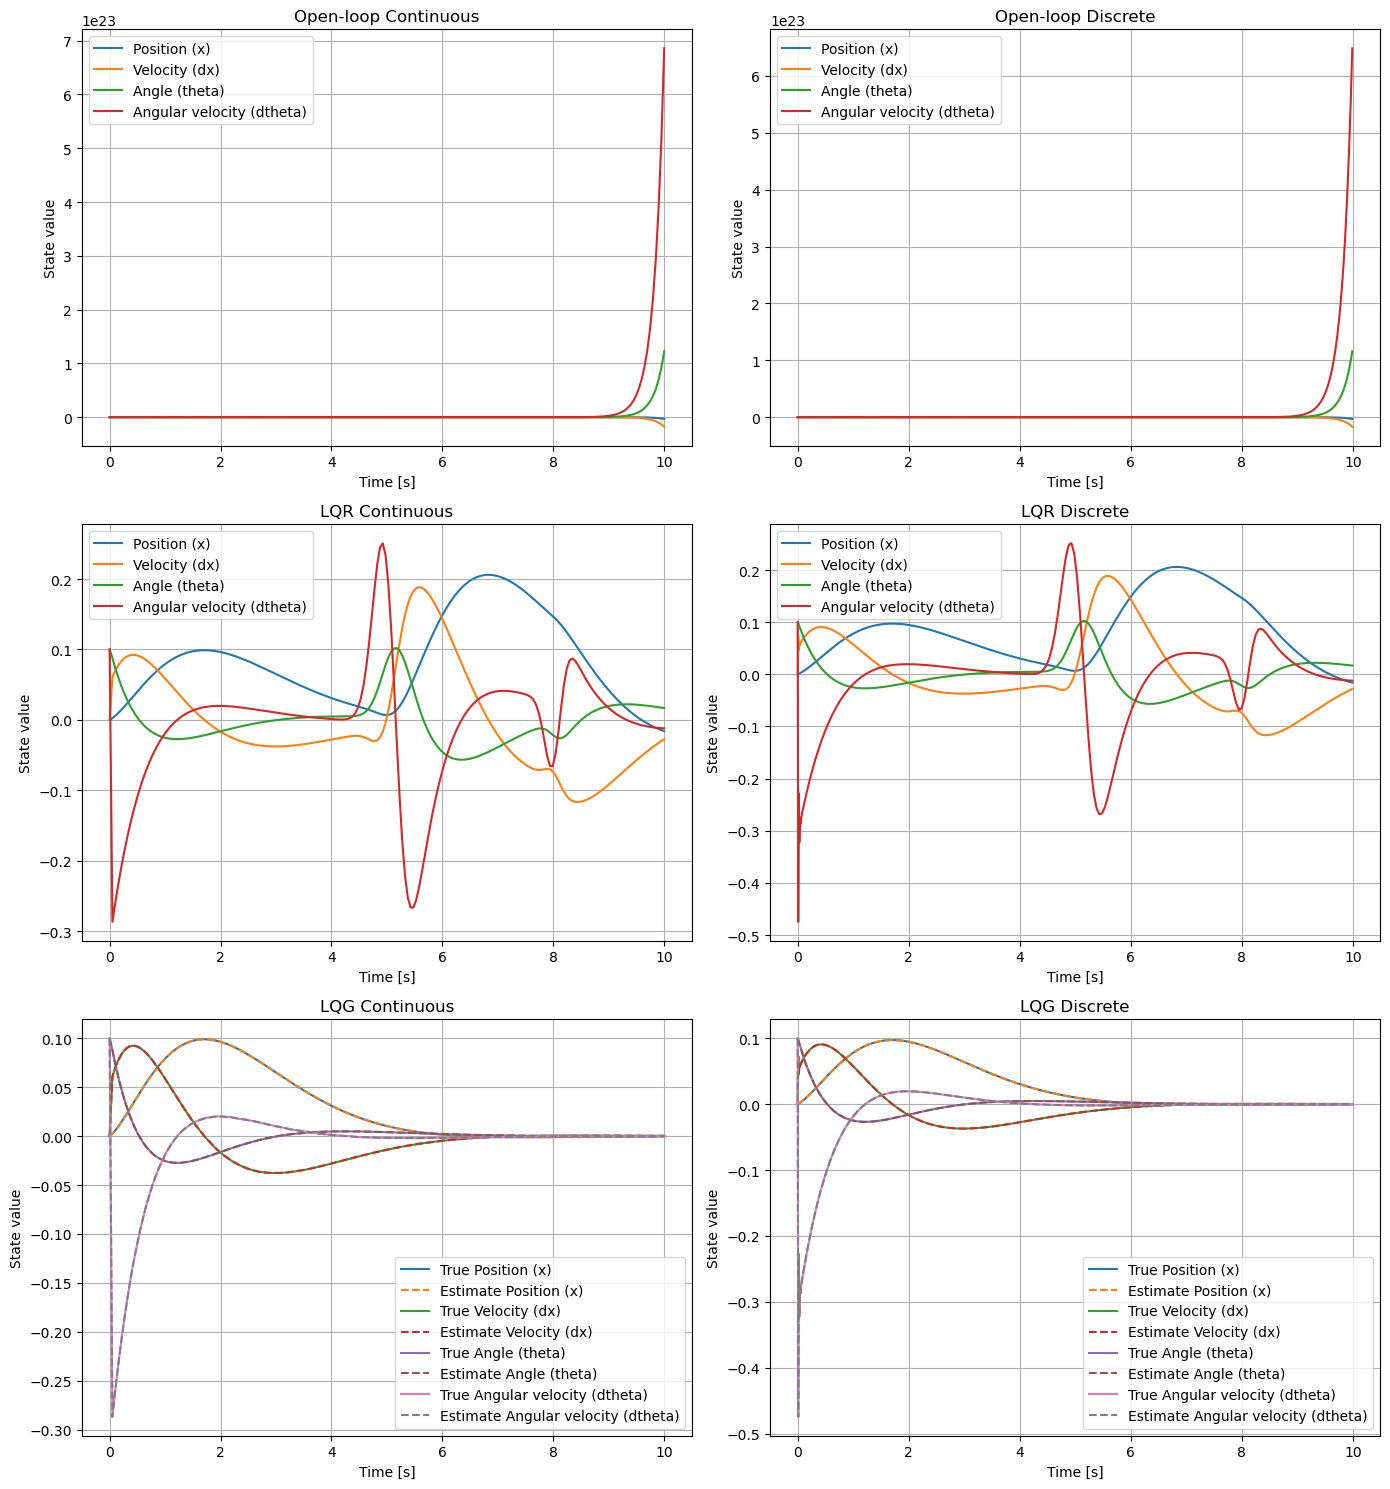

In [137]:
import matplotlib.pyplot as plt

state_labels = ['Position (x)', 'Velocity (dx)', 'Angle (theta)', 'Angular velocity (dtheta)']

plt.figure(figsize=(14, 15))

# First plot: Open-loop Continuous
plt.subplot(3, 2, 1)
for i in range(4):
    plt.plot(T_out_noControl_c, x_out_noControl_c[i], label=state_labels[i])
plt.title('Open-loop Continuous')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Second plot: Open-loop Discrete
plt.subplot(3, 2, 2)
for i in range(4):
    plt.plot(T_out_noControl_d, x_out_noControl_d[i], label=state_labels[i])
plt.title('Open-loop Discrete')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Third plot: LQR Continuous
plt.subplot(3, 2, 3)
for i in range(4):
    plt.plot(T_out_lqr_c, x_out_lqr_c[i], label=state_labels[i])
plt.title('LQR Continuous')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Fourth plot: LQR Discrete
plt.subplot(3, 2, 4)
for i in range(4):
    plt.plot(T_out_lqr_d, x_out_lqr_d[i], label=state_labels[i])
plt.title('LQR Discrete')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Fifth plot: LQG Continuous
plt.subplot(3, 2, 5)
for i in range(4):
    plt.plot(T_lqg_c, x_true_lqg_c[i], label=f'True {state_labels[i]}')
    plt.plot(T_lqg_c, x_hat_lqg_c[i], '--', label=f'Estimate {state_labels[i]}')
plt.title('LQG Continuous')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

# Sixth plot: LQG Discrete
plt.subplot(3, 2, 6)
for i in range(4):
    plt.plot(T_lqg_d, x_true_lqg_d[i], label=f'True {state_labels[i]}')
    plt.plot(T_lqg_d, x_hat_lqg_d[i], '--', label=f'Estimate {state_labels[i]}')
plt.title('LQG Discrete')
plt.xlabel('Time [s]')
plt.ylabel('State value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


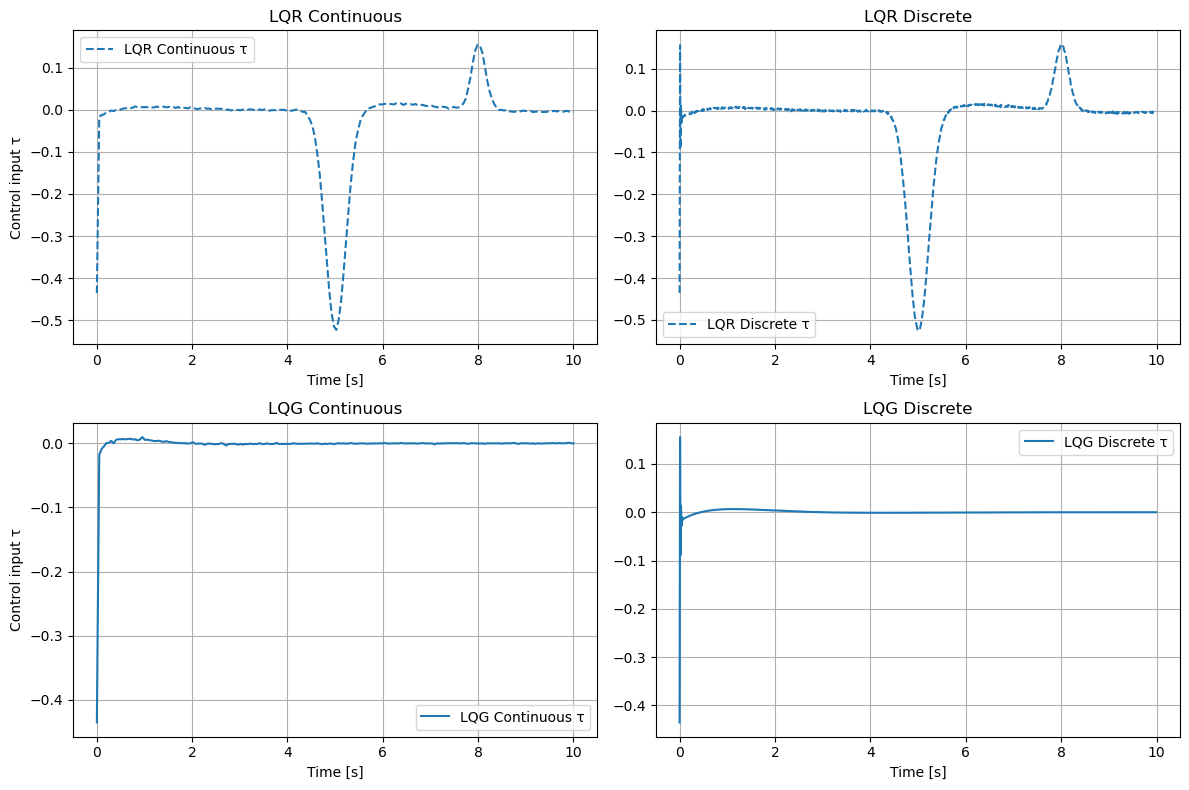

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# Interpolate continuous tau to match T_c
tau_lqg_c_interp = np.interp(T_c, np.linspace(T_lqg_c[0], T_lqg_c[-1], len(tau_lqg_c)), tau_lqg_c)

# Create 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ====== (1,1) LQR Continuous ======
axes[0, 0].plot(T_c, tau_lqr_c, label='LQR Continuous τ', linestyle='--')
axes[0, 0].set_title('LQR Continuous')
axes[0, 0].set_xlabel('Time [s]')
axes[0, 0].set_ylabel('Control input τ')
axes[0, 0].legend()
axes[0, 0].grid(True)

# ====== (1,2) LQR Discrete ======
axes[0, 1].plot(T_out_lqr_d, tau_lqr_d, label='LQR Discrete τ', linestyle='--')
axes[0, 1].set_title('LQR Discrete')
axes[0, 1].set_xlabel('Time [s]')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ====== (2,1) LQG Continuous ======
axes[1, 0].plot(T_c, tau_lqg_c_interp, label='LQG Continuous τ', linestyle='-')
axes[1, 0].set_title('LQG Continuous')
axes[1, 0].set_xlabel('Time [s]')
axes[1, 0].set_ylabel('Control input τ')
axes[1, 0].legend()
axes[1, 0].grid(True)

# ====== (2,2) LQG Discrete ======
axes[1, 1].plot(T_lqg_d, tau_lqg_d, label='LQG Discrete τ', linestyle='-')
axes[1, 1].set_title('LQG Discrete')
axes[1, 1].set_xlabel('Time [s]')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()
